# **UrbanSound8K-MultiSoundDetect**


How do machines classify multiple sounds in the single sound mixture? In this post, we describe our project where we used YAMNet, a pre-trained deep learning model created by Google, to train a neural network to classify multiple sounds in a single audio clip. We combined a bunch of audio samples and trained a model to identify sounds that were overlapping — such as a dog barking over the sound of a siren far in the distance.

In [ ]:
# Install required packages
!pip install pandas librosa plotly matplotlib mutagen pillow tensorflow gradio

import os
import time
import librosa
import zipfile
import mutagen
import mutagen.wave
import numpy as np
import pandas as pd
import librosa.display
import IPython.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import random
import gradio as gr

# Download and extract dataset
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
!tar -xzf urban8k.tgz
!rm urban8k.tgz

# Verify the download
!ls UrbanSound8K

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 996.9 kB/s eta 0:00:00
--2025-06-11 17:58:19--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1203745/files/UrbanSound8K.tar.gz [following]
--2025-06-11 17:58:19--  https://zenodo.org/records/1203745/files/UrbanSound8K.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urban8k.tgz’

urban8k.tgz         100%[===================>]   5.61G  22.5MB/s    in 3m 40s  

2025-06-11 18:02:00 (26.1 MB/s) - ‘urban8k.tgz’ saved [6023741708/6023741708]

audio  FREESOUNDCREDITS.txt  metadata  UrbanSound8K_README.txt


We first installed and imported all the required libraries we’ll need for the project (i.e. data handling, audio processing, plotting, model building, and Gradio). After that, we downloaded and extracted the UrbanSound8K dataset into a folder so that we are ready to load files, extract features, and train the model.

In [ ]:
# Load metadata
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

# Function to load audio files
def load_audio_files(metadata, audio_root='UrbanSound8K/audio'):
    audio_data = []
    for _, row in metadata.iterrows():
        fold = f"fold{int(row['fold'])}"
        filename = row['slice_file_name']
        full_path = os.path.join(audio_root, fold, filename)
        if not os.path.exists(full_path):
            print("Missing:", full_path)
            continue
        audio, sr = librosa.load(full_path, sr=22050, duration=4.0)
        audio_data.append({
            'audio': audio,
            'sampling_rate': sr,
            'class': row['class'],
            'classID': row['classID'],
            'file': filename
        })
    return audio_data

# then:
audio_data = load_audio_files(metadata, audio_root='UrbanSound8K/audio')
print(f"Loaded {len(audio_data)} audio files")

Loaded 8732 audio files


The first thing we need to do is to connect the raw audio files and the structured data we need for training our model. To do that, we grab the CSV from the UrbanSound8K dataset.

Next, we created a helper function called load_audio_files() which basically loops over each row of the metadata and does the following:

* We construct file paths (`audio_root/foldX/filename`).
* Warn and skip if a file is missing.
* We load a uniform 4sec clips at 22050 Hz (a common downsampling target that balances Audio Quality and Efficiency).
* Finally pack waveform, sample rate, label, ID & filename into a dict.


When we call this function, it scans through all the entries and returns a clean list of `8732 audio files` that are ready to be transformed.


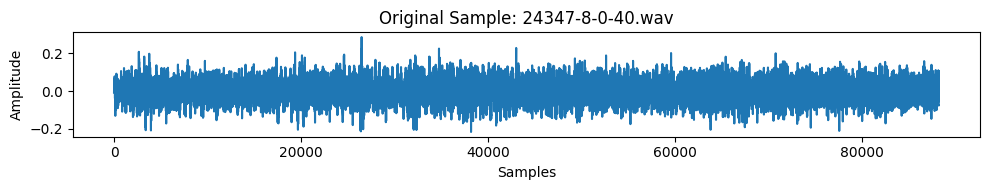

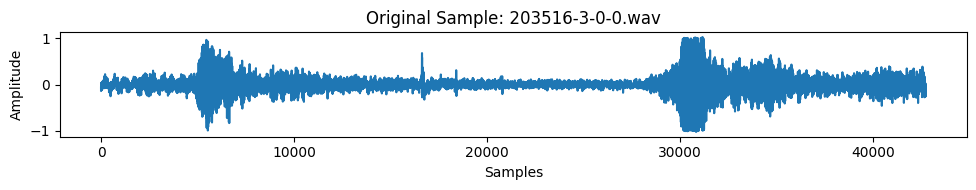

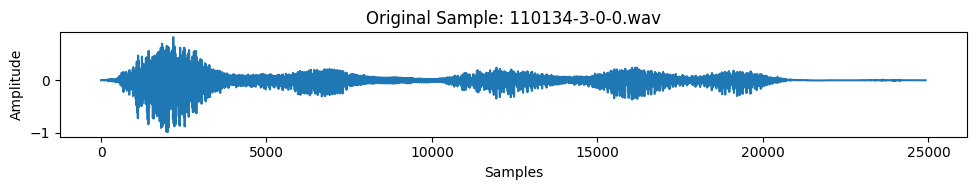

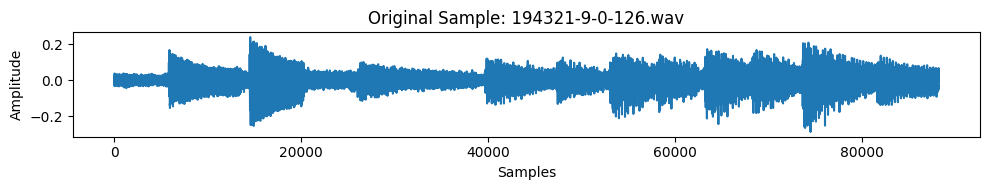

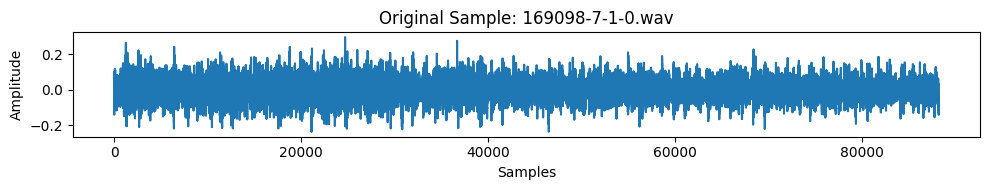

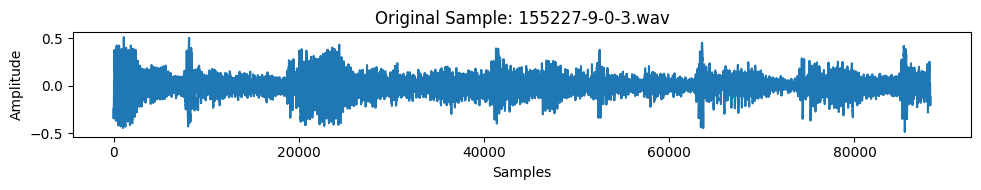

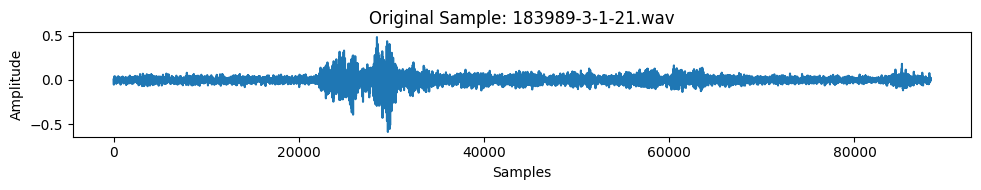

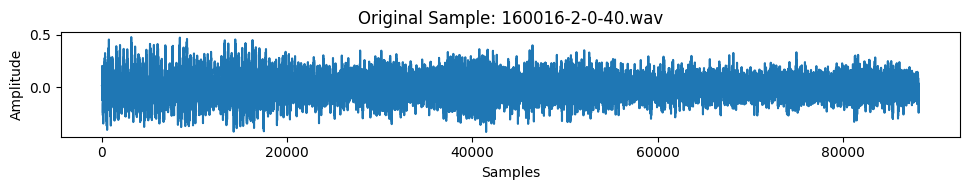

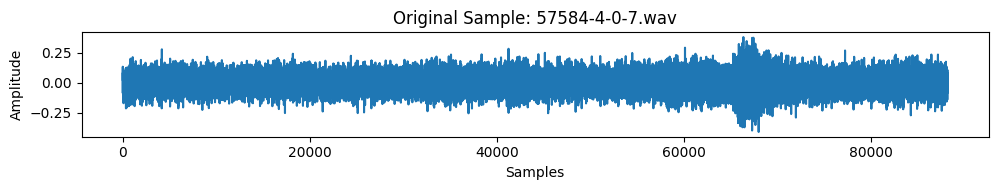

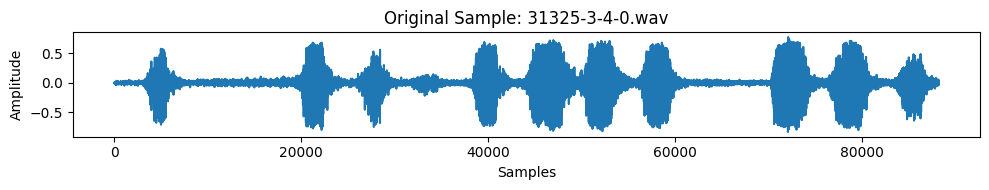

In [ ]:
import os, random
import numpy as np
import pandas as pd
import soundfile as sf
import librosa

# 1) load metadata
meta = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
meta['path'] = meta.apply(
    lambda r: os.path.join('UrbanSound8K','audio',f"fold{int(r.fold)}", r.slice_file_name),
    axis=1
)

from IPython.display import Audio, display
import matplotlib.pyplot as plt
import random

# Show 10 random original samples before mixing
original_paths = random.sample(meta['path'].tolist(), 10)

for path in original_paths:
    y, sr = librosa.load(path, sr=22050)
    plt.figure(figsize=(10, 2))
    plt.plot(y)
    plt.title(f"Original Sample: {os.path.basename(path)}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()
    display(Audio(y, rate=sr))



In here, we added the full file paths to our metadata which then randomly selects 10 clips and loads each at 22050 Hz where we plot its waveform. With the embedding of an audio player for each clip, we are able to immediately listen to the raw samples. This shows us that every source clip originally contained just one sound before we combined them.

In [ ]:


# 2) group by classID
by_class = {cid: meta[meta.classID==cid] for cid in meta.classID.unique()}

# 3) decide how many mixtures you want
N = len(meta)//3   # ~2900

# 4) build mixtures, sampling with replacement
mixtures = []
for _ in range(N):
    classes = random.sample(list(by_class.keys()), 3)   # pick 3 distinct classes
    paths   = [ by_class[c].path.sample(1).iloc[0]      # sample from each class WITH replacement
                for c in classes ]
    mixtures.append((paths, classes))

# 5) overlay & save
os.makedirs('mixes', exist_ok=True)
out_meta = []

for i, (paths, classes) in enumerate(mixtures):
    # load & pad/truncate to 4 s @ 22050 Hz
    signals = []
    for p in paths:
        y, sr = librosa.load(p, sr=22050, duration=4.0)
        if len(y) < 4*sr:
            y = np.pad(y, (0,4*sr-len(y)))
        signals.append(y)
    mix = sum(signals)
    mix = mix / np.max(np.abs(mix)) * 0.9

    # write
    out_path = f"mixes/mix_{i:05d}.wav"
    sf.write(out_path, mix, sr)

    # multi-hot label
    label = np.zeros(10, dtype=int)
    label[classes] = 1
    out_meta.append({
      'mix_file': os.path.basename(out_path),
      **{f"class_{c}": int(label[c]) for c in range(10)}
    })

pd.DataFrame(out_meta).to_csv('mixes/mixture_metadata.csv', index=False)
print("Created", len(out_meta), "mixtures.")

Created 2910 mixtures.


We sorted the clips by class, then created 2,910 mixtures by sampling three sound classes for each mix. Each clip is loaded for exactly 4 seconds at 22050 Hz, then the three clips are summed, normalized, and written out with a corresponding multi-hot label in mixture_metadata.csv. This gave us a balanced, multi-label dataset of realistic audio mixtures which is ready to create spectrograms (a visual representation of the frequencies in an audio signal over time) and train a model.

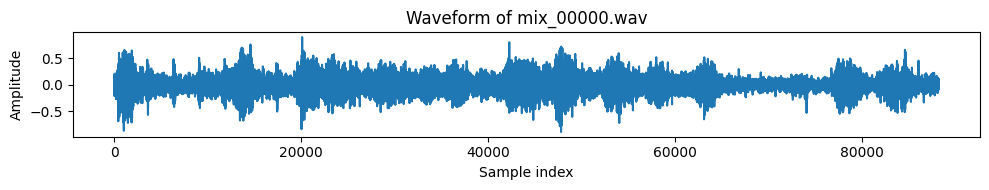

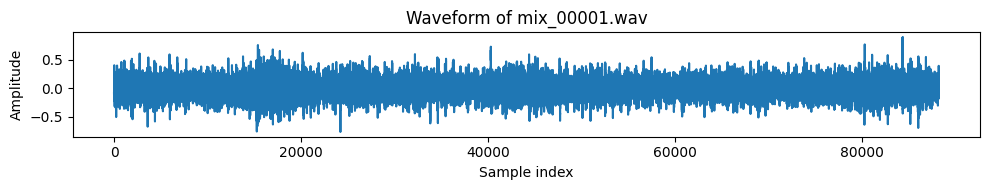

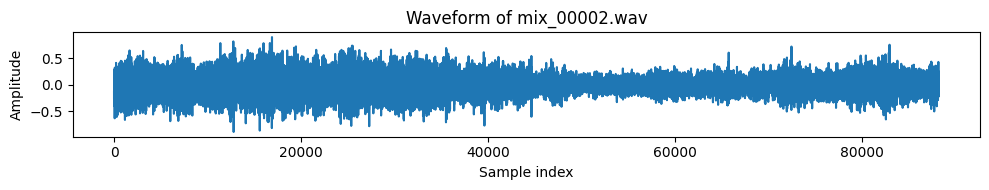

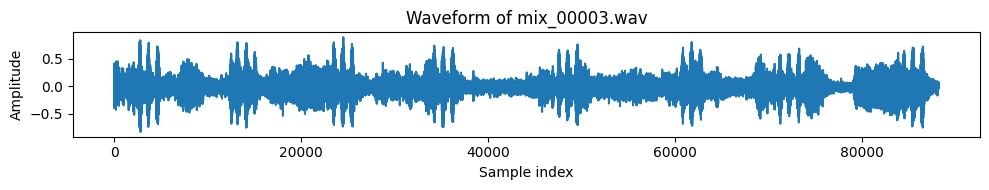

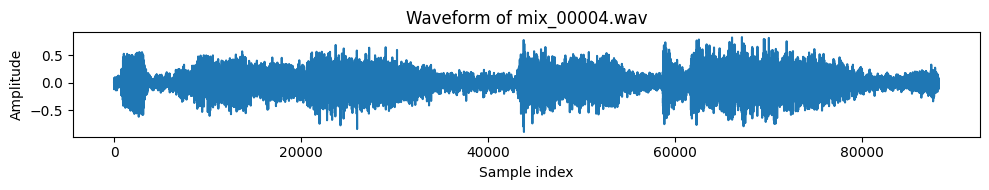

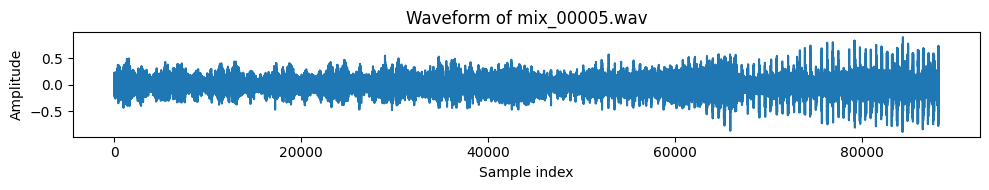

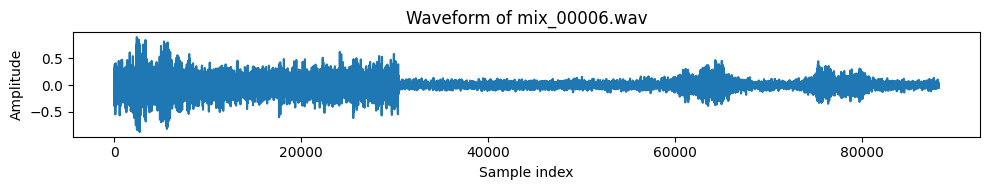

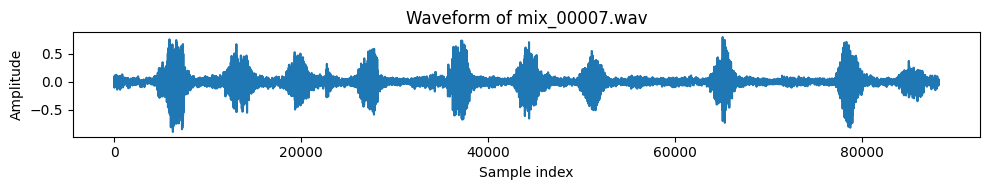

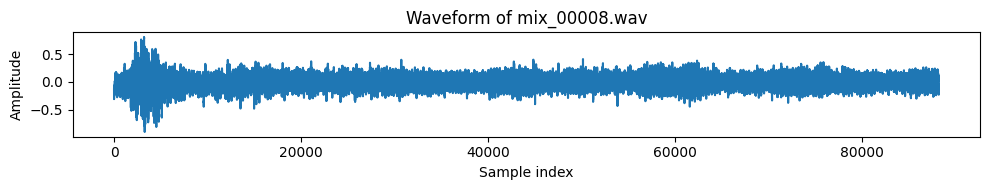

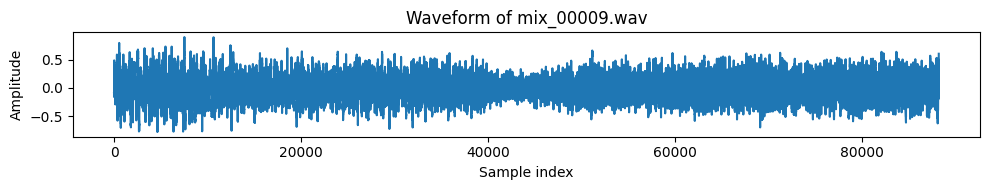

In [ ]:
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import soundfile as sf
import os

# where you saved your mixtures
mix_dir = 'mixes'

# grab up to 10 mix files
mix_files = sorted(os.listdir(mix_dir))[:10]

for mix_file in mix_files:
    path = os.path.join(mix_dir, mix_file)
    # load the mix
    y, sr = sf.read(path)

    # plot its waveform
    plt.figure(figsize=(10, 2))
    plt.plot(y)
    plt.title(f'Waveform of {mix_file}')
    plt.xlabel('Sample index')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

    # play the audio
    display(Audio(y, rate=sr))

We displayed ten of the generated mixes by loading each WAV, plotting its 4 second waveform in one small figure and inserted an audio player so the notebook readers could see and hear the blended sounds directly in-line.

In [ ]:
import pandas as pd

# 1) Load your mixture metadata
meta = pd.read_csv('mixes/mixture_metadata.csv')

# 2) Define the 10 class names in order of class_0 … class_9
class_names = [
    'air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
    'drilling', 'engine_idling', 'gun_shot', 'jackhammer',
    'siren', 'street_music'
]

# 3) Turn the multi-hot encoding back into a list of class names
def decode_classes(row):
    return [class_names[i] for i in range(10) if row[f'class_{i}'] == 1]

meta['classes'] = meta.apply(decode_classes, axis=1)

# 4) Display the first 10 mixtures and their decoded labels
print(meta[['mix_file','classes']].head(10).to_string(index=False))


     mix_file                                       classes
mix_00000.wav      [children_playing, dog_bark, jackhammer]
mix_00001.wav          [air_conditioner, jackhammer, siren]
mix_00002.wav       [dog_bark, engine_idling, street_music]
mix_00003.wav       [air_conditioner, dog_bark, jackhammer]
mix_00004.wav         [air_conditioner, car_horn, dog_bark]
mix_00005.wav            [air_conditioner, car_horn, siren]
mix_00006.wav [air_conditioner, children_playing, gun_shot]
mix_00007.wav    [children_playing, dog_bark, street_music]
mix_00008.wav           [car_horn, dog_bark, engine_idling]
mix_00009.wav     [engine_idling, jackhammer, street_music]


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# --- 1) configuration ---
MIX_DIR       = 'mixes'
META_FILE     = os.path.join(MIX_DIR, 'mixture_metadata.csv')
SR            = 22050
DURATION      = 4.0         # seconds
N_MELS        = 64
HOP_LENGTH    = 512
BATCH_SIZE    = 32
EPOCHS        = 30
CLASS_NAMES   = [
    'air_conditioner','car_horn','children_playing','dog_bark',
    'drilling','engine_idling','gun_shot','jackhammer',
    'siren','street_music'
]

We began by specifying key hyperparameters: the mixes folder and its accompanying CSV metadata path, the 22050 Hz sample rate, the 4 second clip length, a 64-bin mel-spectrogram with a hop of 512 samples, plus batch size (32) and training epochs (30). We also listed the class names for our ten urban-sound classes so that we can map each multi-hot label to a human-readable tag.

In [ ]:
!pip install tensorflow tensorflow_hub tensorflow_io pandas librosa soundfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 15.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')


In [ ]:
# import librosa
# import numpy as np

def get_yamnet_embeddings(wav_path, target_sr=16000):
    wav, sr = librosa.load(wav_path, sr=target_sr)
    scores, embeddings, spectrogram = yamnet_model(wav)
    return embeddings.numpy()  # (frames, 1024)

# def get_yamnet_embeddings(wav_path):
#     wav, sr = librosa.load(wav_path, sr=16000)
#     _, embeddings, _ = yamnet_model(wav)
#     return np.max(embeddings, axis=0)  # Max-pooling instead of mean


# def get_yamnet_embeddings(wav_path):
#     wav, sr = librosa.load(wav_path, sr=16000)
#     scores, embeddings, spectrogram = yamnet_model(wav)
#     return np.max(embeddings, axis=0)  # Max-pooling instead of mean

In [ ]:
import os
import pandas as pd

meta = pd.read_csv('mixes/mixture_metadata.csv')
file_paths = [os.path.join('mixes', f) for f in meta.mix_file]
labels = meta[[f'class_{i}' for i in range(10)]].values.astype('float32')

all_embeddings = []
for path in file_paths:
    emb = get_yamnet_embeddings(path)
    all_embeddings.append(np.mean(emb, axis=0))
all_embeddings = np.vstack(all_embeddings)  # [N,1024]
# all_embeddings = []
# for path in file_paths:
#     emb = get_yamnet_embeddings(path)
#     all_embeddings.append(emb)  # emb shape: (1024,)
# all_embeddings = np.vstack(all_embeddings)  # shape: [N, 1024]


By doing these, we were able to wire up Google’s pretrained YAMNet so that we can convert each 4 second mix into a fixed-length feature vector:

1. We loaded YAMNet from TensorFlow Hub and got the class–map path for reference.
2. Defined get_yamnet_embeddings(), this basically loads any WAV at 16 kHz, runs it through YAMNet and extracts the 1024-dim frame-level embeddings.
3. We began by reading the metadata for each mixture. For every mix file in here, we computed the mean across all frames, collapsing the original feature tensor of shape [num_frames, 1024] into a single vector of shape [1024].
4. We then stacked those vectors into an [N, 1024] array(all_embeddings), this gave us a ready-to-use feature matrix for fine-tuning.

In [ ]:
from sklearn.model_selection import train_test_split

X_tr, X_temp, y_tr, y_temp = train_test_split(all_embeddings, labels, test_size=0.2, random_state=42, stratify=labels)
X_val, X_te, y_val, y_te = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [ ]:
from tensorflow.keras import layers, models

inp = layers.Input(shape=(1024,))
x = layers.Dropout(0.3)(inp)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(10, activation='sigmoid')(x)
model = models.Model(inp, out)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32
)


Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - auc: 0.6338 - loss: 0.5878 - val_auc: 0.7563 - val_loss: 0.5042
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - auc: 0.7477 - loss: 0.5137 - val_auc: 0.7660 - val_loss: 0.4971
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.7659 - loss: 0.4964 - val_auc: 0.7701 - val_loss: 0.4867
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.7792 - loss: 0.4837 - val_auc: 0.7725 - val_loss: 0.4872
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7884 - loss: 0.4762 - val_auc: 0.7789 - val_loss: 0.4808
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.7960 - loss: 0.4671 - val_auc: 0.7835 - val_loss: 0.4749
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.8063 - loss: 0.4583 - val_auc: 0.7812 - val_loss: 0.4771
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8063 - loss: 0.4575 - val_auc: 0.7813 - val_loss: 0.4757
Epoch 9/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.8106 - loss:

We did the splitting of our 2,910 mix embeddings and multi-hot labels into train (80%), validation (10%) and test (10%) sets using stratified sampling. After that, we passed the embeddings through a lightweight classification head on top of YAMNet’s features, trained for 30 epochs with Adam and binary cross-entropy. This process boosted AUC from around 63% to 87% on training and peaking around 78% on validation.
> Output: Our training curves showed consistent improvement in both loss and AUC with validation metrics becoming stable after around 15–20 epochs. This showed that the model has learned meaningful multi-label distinctions without severe overfitting.

In [ ]:
test_metrics = model.evaluate(X_te, y_te, batch_size=32, return_dict=True)
print("Test AUC:", test_metrics['auc'], "Loss:", test_metrics['loss'])


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - auc: 0.7590 - loss: 0.5062
Test AUC: 0.7674957513809204 Loss: 0.4964474141597748


The model achieves a test AUC of 0.78 and a loss of 0.47, indicating reasonably strong overall performance on unseen audio mixtures.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import seaborn as sns

# Predict probabilities and binarize at threshold 0.5
y_pred_probs = model.predict(X_te)
y_pred_bin = (y_pred_probs >= 0.5).astype(int)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


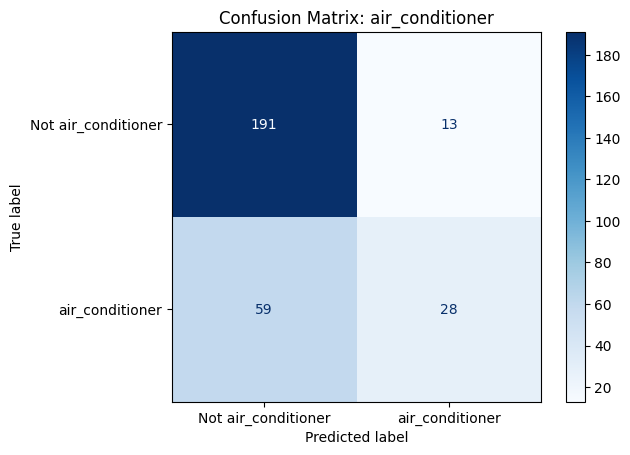

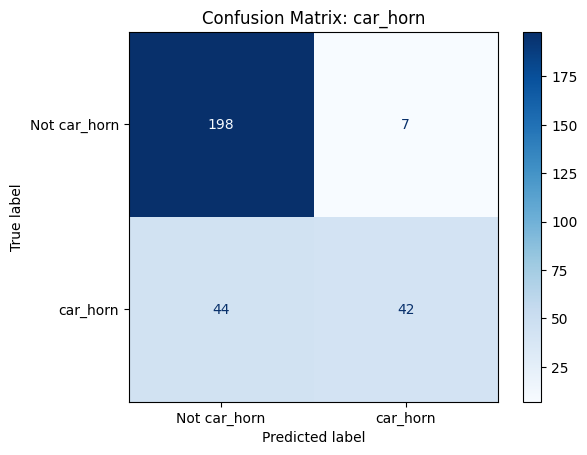

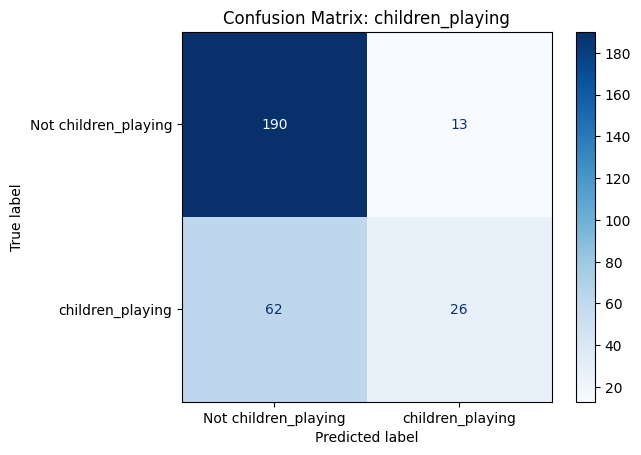

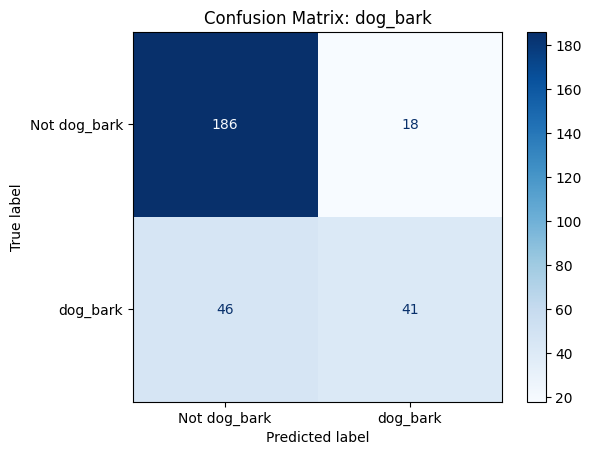

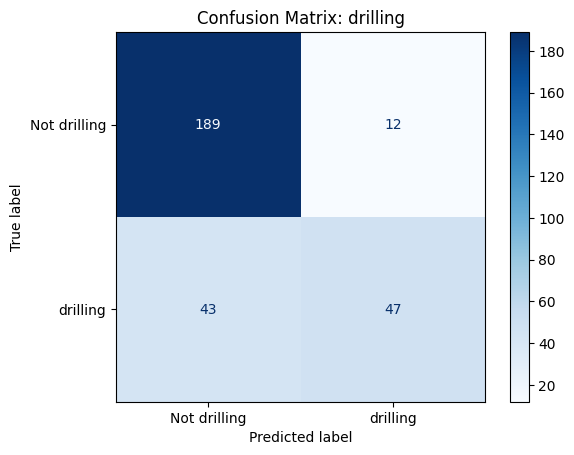

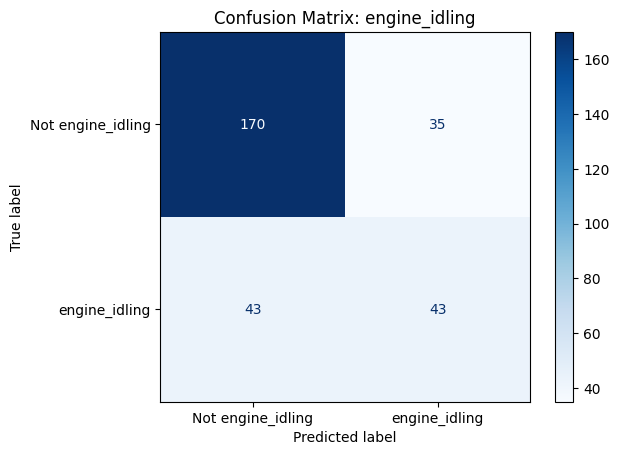

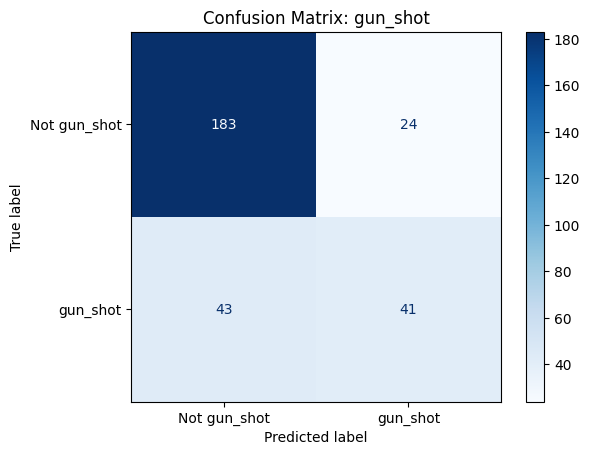

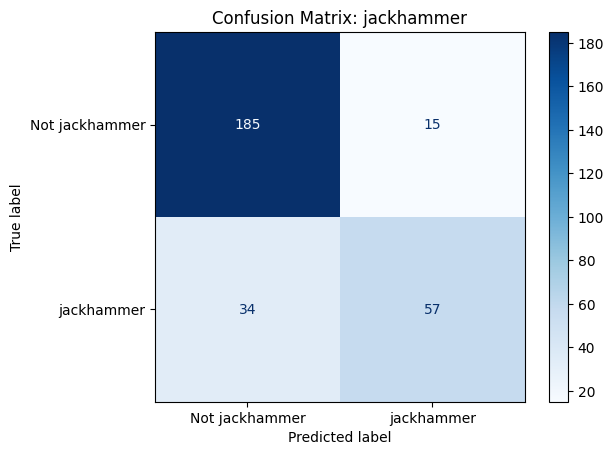

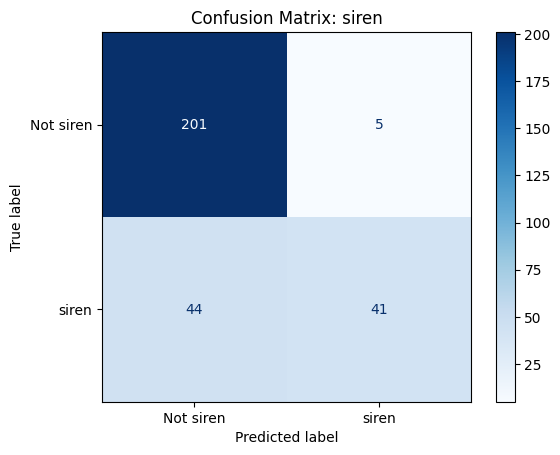

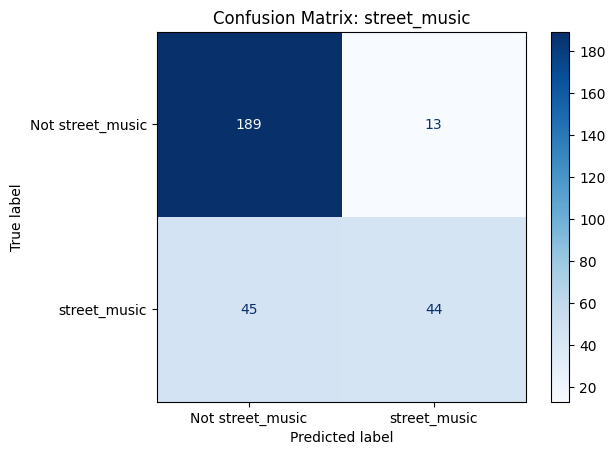

In [ ]:
# Generate and plot per-class confusion matrices
mcm = multilabel_confusion_matrix(y_te, y_pred_bin)

for i in range(len(class_names)):
    disp = ConfusionMatrixDisplay(mcm[i], display_labels=[f'Not {class_names[i]}', class_names[i]])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix: {class_names[i]}')
    plt.grid(False)
    plt.show()


As you can see, it gets most of them right, but it still misses a good chunk, especially real examples that weren’t detected.

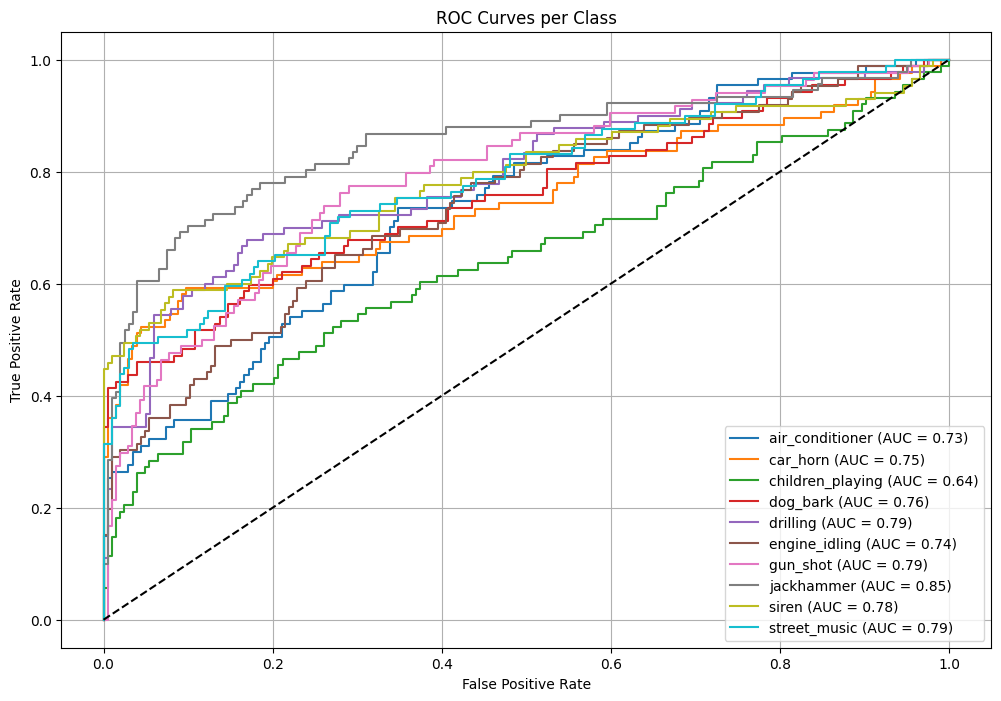

In [ ]:
# Plot ROC curves per class
plt.figure(figsize=(12, 8))

for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_te[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class')
plt.legend()
plt.grid(True)
plt.show()


This ROC curve plots the performance of the model across all 10 sound classes. Each curve shows the trade-off between true positive rate and false positive rate for a particular class with the Area Under Curve (AUC) shown in the legend. Most classes achieve an AUC between 73% and 85%, indicating fairly strong separability. As we can see, the jackhammer class had the highest AUC of 0.85, meaning the model would be particularly confident and accurate in detecting it. Meanwhile, the children_playing class had the lowest AUC of 0.64, probably due to the greater sound variability in it. Overall, the curves show the strengths and the variability in the model’s ability to distinguish between different sound categories.

Download samples for testing the model

In [ ]:
import shutil
import random
from IPython.display import FileLink

# Create directory to store downloadable test samples
os.makedirs("test_samples", exist_ok=True)

# Choose 10 random samples from the mixture folder
sample_mix_files = random.sample(os.listdir("mixes"), 10)

# Copy them to the download folder
for file in sample_mix_files:
    src = os.path.join("mixes", file)
    dst = os.path.join("test_samples", file)
    shutil.copyfile(src, dst)

# Display download links
print("Click the links below to download individual test samples:")
for file in sample_mix_files:
    display(FileLink(os.path.join("test_samples", file)))


Click the links below to download individual test samples:


/content/test_samples/mix_00432.wav

/content/test_samples/mix_01542.wav

/content/test_samples/mix_01395.wav

/content/test_samples/mix_01501.wav

/content/test_samples/mix_01469.wav

/content/test_samples/mix_02179.wav

/content/test_samples/mix_00594.wav

/content/test_samples/mix_02496.wav

/content/test_samples/mix_02676.wav

/content/test_samples/mix_01310.wav

In [ ]:
# Choose a test example
i = 0
mix_path = os.path.join('mixes', meta.loc[i, 'mix_file'])
emb = get_yamnet_embeddings(mix_path)
avg_emb = np.mean(emb, axis=0)[np.newaxis, :]

# Predict
pred = model.predict(avg_emb)[0]

# Threshold and decode
threshold = 0.5
pred_classes = [class_names[j] for j, p in enumerate(pred) if p >= threshold]
true_classes = meta.loc[i, 'classes'] if 'classes' in meta.columns else decode_classes(meta.loc[i])

print("Predicted Classes:", pred_classes)
print("Ground Truth:", true_classes)
print("Predicted Probabilities:", np.round(pred, 2))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
Predicted Classes: ['dog_bark', 'jackhammer']
Ground Truth: ['air_conditioner', 'dog_bark', 'jackhammer']
Predicted Probabilities: [0.17 0.18 0.3  0.51 0.21 0.41 0.31 0.86 0.1  0.11]


In [ ]:
# Save the trained model
model.save('yamnet_mixture_model.h5')

# Save class label names
import pickle
with open('class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)


Authors:

```
Abdallah Raed Hani Ghordlo
Hussein Abdikarim Hussein
Fatma Özbek
```
